<a href="https://colab.research.google.com/github/yslikitha/Traffic-volume-Forecasting/blob/main/TrafficVolume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [51]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")

In [55]:
# Navigate to data directory
import os
os.chdir('/content/drive/My Drive/Placement/Projects/TermProject')
dataset_path = '/content/drive/My Drive/Placement/Projects/TermProject/traffic_volume2.csv'
data = pd.read_csv(dataset_path)

In [56]:
data.head()

,date,volume
0,01-01-2018,10000
1,01-02-2018,12000
2,01-03-2018,11500
3,01-04-2018,10200
4,01-05-2018,9800


In [57]:
# Convert the 'date_time' column to a datetime object
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

# Set 'date_time' as the index if you want (optional)
data.set_index('date', inplace=True)

data.head()

,volume
date,
2018-01-01,10000
2018-02-01,12000
2018-03-01,11500
2018-04-01,10200
2018-05-01,9800


In [58]:
data.tail(15)

,volume
date,
2019-10-01,11200
2019-11-01,12800
2019-12-01,14700
2020-01-01,16500
2020-02-01,17200
2020-03-01,16400
2020-04-01,15200
2020-05-01,13700
2020-06-01,12000


In [59]:
data.isnull().sum()

,0
volume,0


 Visualise the time series

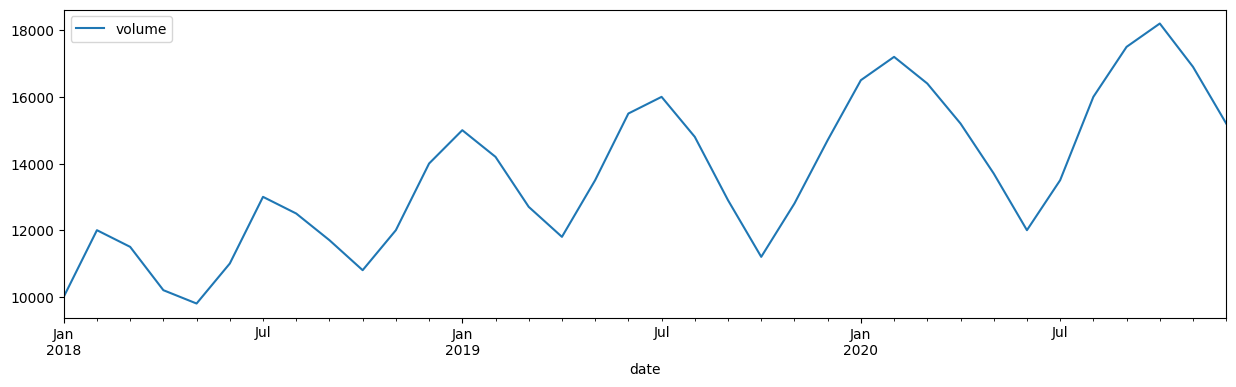

In [60]:
data.plot(figsize=(15, 4))
plt.show()

In [61]:
# Split the data into training and testing sets
train = data[:'2020-04-01	']
test = data['2020-05-01':]

In [62]:
print((len(train), len(test)))

(28, 8)


In [63]:
train.tail()

,volume
date,
2019-12-01,14700
2020-01-01,16500
2020-02-01,17200
2020-03-01,16400
2020-04-01,15200


In [64]:
test.head()

,volume
date,
2020-05-01,13700
2020-06-01,12000
2020-07-01,13500
2020-08-01,16000
2020-09-01,17500


In [65]:
data.describe()

,volume
count,36.000000
mean,13663.888889
std,2289.747681
min,9800.000000
25%,11950.000000
50%,13500.000000
75%,15275.000000
max,18200.000000


Time series structural Analysis

In [66]:
def ts_decompose(data, model="additive"):

    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(data)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

    result = seasonal_decompose(data, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(data, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)


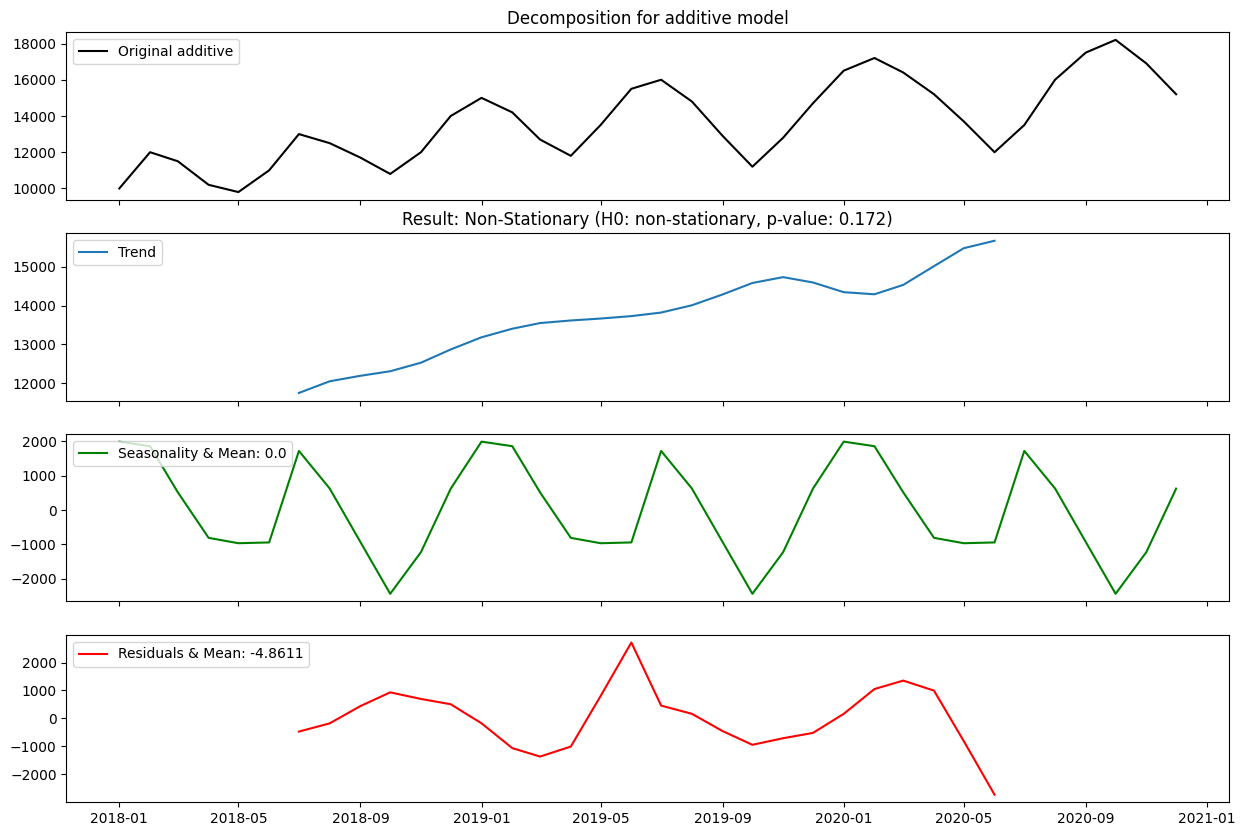

In [67]:
ts_decompose(data)

1. Simple exponential smoothing

Best alpha: 0.8
Best MAE: 1775.00
Final MAE: 1775.00
Final MAPE: 12.07%


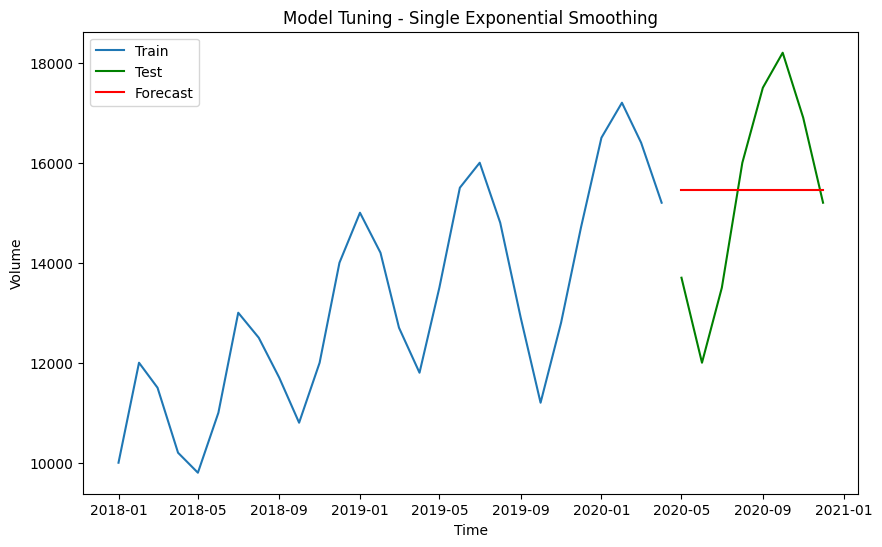

In [88]:
#Plots the training data, test data, and forecasted data.
def plot_model(train, test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Train')
    plt.plot(test.index, test, label='Test',color='green')
    plt.plot(test.index, y_pred, label='Forecast', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()
#Finds the optimal smoothing level (alpha) for the Simple Exponential Smoothing model.
def ses_optimizer(train, test, alphas, step):
    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae
#Tunes the SES model by finding the best smoothing level (alpha) and plots the results.
def ses_model_tuning(train, test, step, title="Model Tuning - Single Exponential Smoothing"):
    alphas = np.arange(0.8, 1, 0.01)

    best_alpha, best_mae = ses_optimizer(train, test, alphas, step=step)

    if best_alpha is None:
        print("No valid alpha value found.")
        return

    final_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred)

    print(f"Best alpha: {best_alpha}")
    print(f"Best MAE: {best_mae:.2f}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape * 100:.2f}%")


    plot_model(train, test, y_pred, title)
ses_model_tuning(train, test, step=8)

2. Double exponential Smoothing

Best alpha: 0.91
Best beta: 0.01
Final MAE: 1608.54
Final MAPE: 11.42%


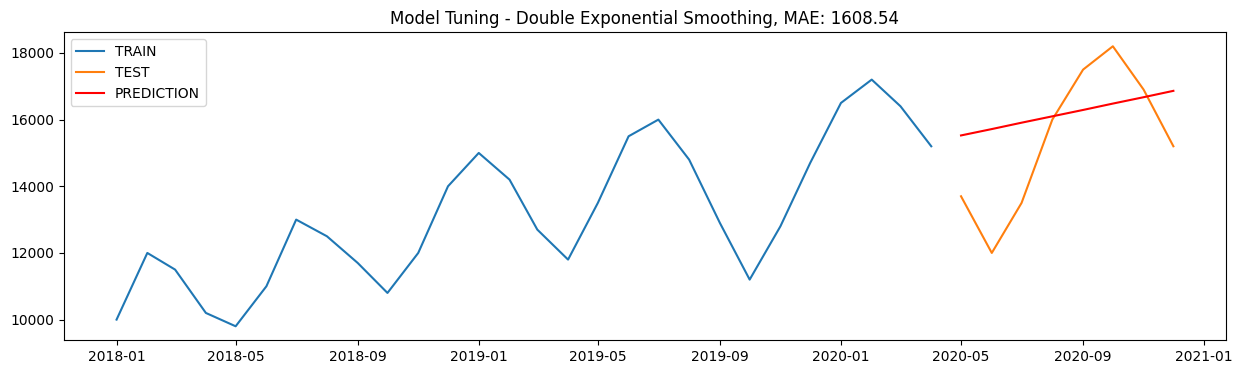

In [89]:
#Plots the training data, test data, and forecasted data along with MAE.
def plot_model(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    plt.figure(figsize=(15, 4))
    plt.plot(train, label="TRAIN")
    plt.plot(test.index, test, label="TEST")
    plt.plot(test.index, y_pred, label="PREDICTION", color='red')
    plt.title(f"{title}, MAE: {round(mae, 2)}")
    plt.legend()
    plt.show()
#Finds the optimal smoothing levels (alpha and beta) for Double Exponential Smoothing model.
def des_optimizer(train, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae
#Tunes the Double Exponential Smoothing (DES) model by finding the best smoothing levels (alpha and beta)and plots the results.
def des_model_tuning(train, test, step, trend, title="Model Tuning - Double Exponential Smoothing"):
    alphas = np.arange(0.01, 1, 0.10)
    betas = np.arange(0.01, 1, 0.10)
    best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, trend=trend, step=step)

    final_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred)
    # Print the best alpha, best beta, and final MAE
    print(f"Best alpha: {best_alpha}")
    print(f"Best beta: {best_beta}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape * 100:.2f}%")
    plot_model(train, test, y_pred, title)

des_model_tuning(train, test, step=8, trend='add')

Best alpha: 0.91
Best beta: 0.01
Final MAE: 1606.53
Final MAPE: 11.44%


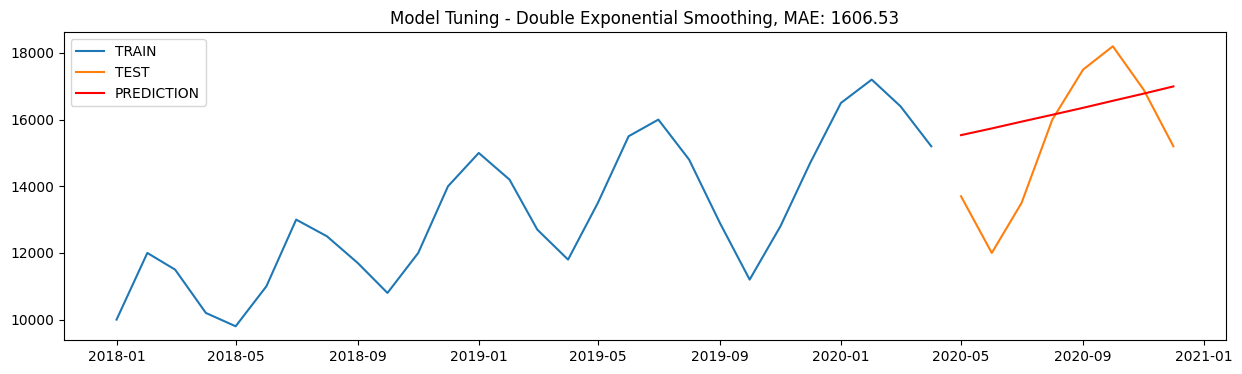

In [90]:
#Plots the training data, test data, and forecasted data along with MAE.
def plot_model(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    plt.figure(figsize=(15, 4))
    plt.plot(train, label="TRAIN")
    plt.plot(test.index, test, label="TEST")
    plt.plot(test.index, y_pred, label="PREDICTION", color='red')
    plt.title(f"{title}, MAE: {round(mae, 2)}")
    plt.legend()
    plt.show()
#Finds the optimal smoothing levels (alpha and beta) for Double Exponential Smoothing model.
def des_optimizer(train, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae
#Tunes the Double Exponential Smoothing (DES) model by finding the best smoothing levels (alpha and beta)and plots the results.
def des_model_tuning(train, test, step, trend, title="Model Tuning - Double Exponential Smoothing"):
    alphas = np.arange(0.01, 1, 0.10)
    betas = np.arange(0.01, 1, 0.10)
    best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, trend=trend, step=step)

    final_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred)
    # Print the best alpha, best beta, and final MAE
    print(f"Best alpha: {best_alpha}")
    print(f"Best beta: {best_beta}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape * 100:.2f}%")
    plot_model(train, test, y_pred, title)

des_model_tuning(train, test, step=8, trend='mul')

3. Triple Exponential Smoothing

Best alpha: 0.05
Best beta: 0.95
Best gamma: 0.15
Final MAE: 2403.90
Final MAPE: 16.05%


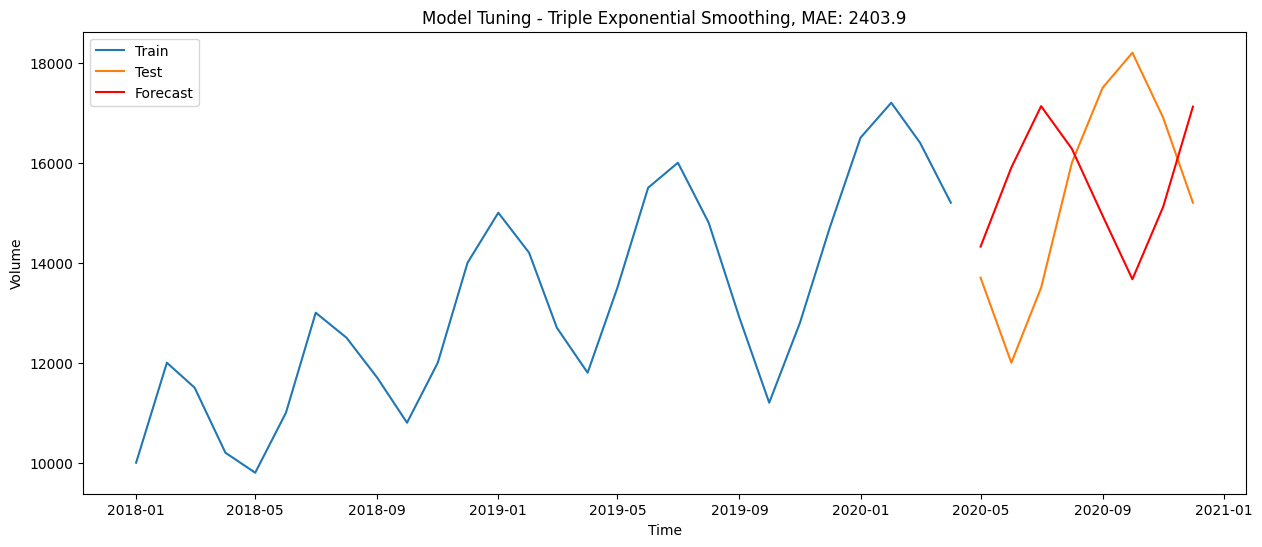

In [91]:
import numpy as np
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Function to plot the results
def plot_model(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, y_pred, label='Forecast', color='red')
    plt.title(f"{title}, MAE: {round(mae, 2)}")
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

# Function to optimize TES parameters
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(
            smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]
        )
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

# Function to tune TES model and plot the results
def tes_model_tuning(train, test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
    alphas = betas = gammas = np.arange(0.05, 1, 0.05)  # Finer search grid
    abg = list(itertools.product(alphas, betas, gammas))
    best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step)

    final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(
        smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma
    )

    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred)

    # Print results
    print(f"Best alpha: {best_alpha:.2f}")
    print(f"Best beta: {best_beta:.2f}")
    print(f"Best gamma: {best_gamma:.2f}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape * 100:.2f}%")

    # Plot the results
    plot_model(train, test, y_pred, title)

    return best_alpha, best_beta, best_gamma, best_mae

best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=8, trend='add', seasonal='add', seasonal_periods=12)


Best alpha: 0.25
Best beta: 0.05
Best gamma: 0.05
Final MAE: 1350.24
Final MAPE: 9.46%


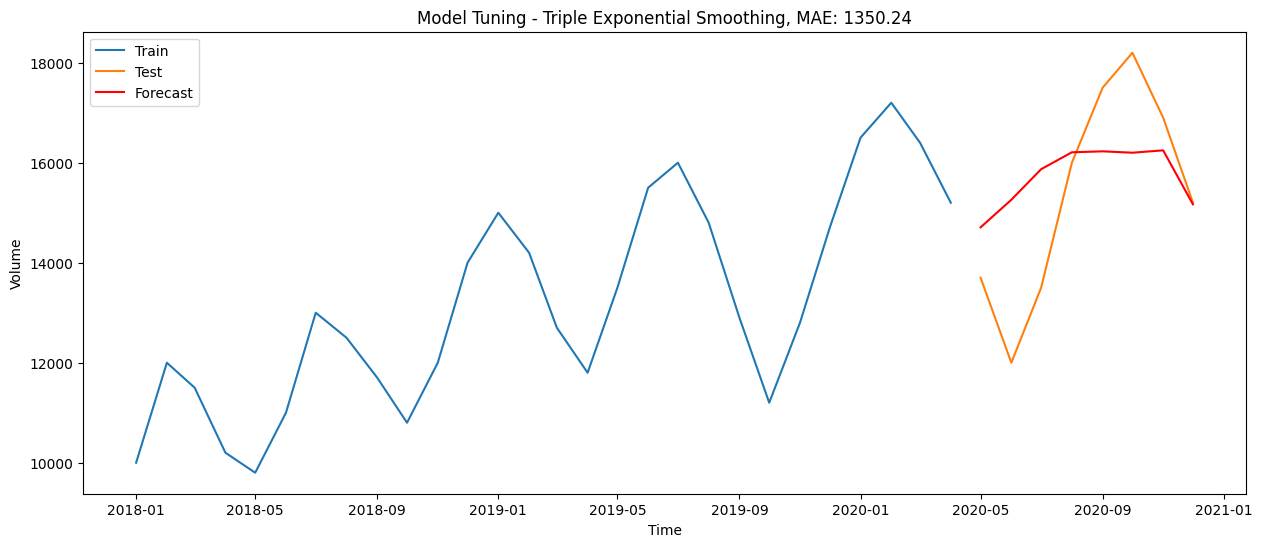

In [92]:
import numpy as np
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Function to plot the results
def plot_model(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, y_pred, label='Forecast', color='red')
    plt.title(f"{title}, MAE: {round(mae, 2)}")
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

# Function to optimize TES parameters
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(
            smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]
        )
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

# Function to tune TES model and plot the results
def tes_model_tuning(train, test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
    alphas = betas = gammas = np.arange(0.05, 1, 0.05)  # Finer search grid
    abg = list(itertools.product(alphas, betas, gammas))
    best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step)

    final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(
        smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma
    )

    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred)

    # Print results
    print(f"Best alpha: {best_alpha:.2f}")
    print(f"Best beta: {best_beta:.2f}")
    print(f"Best gamma: {best_gamma:.2f}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape * 100:.2f}%")

    # Plot the results
    plot_model(train, test, y_pred, title)

    return best_alpha, best_beta, best_gamma, best_mae

best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=8, trend='add', seasonal='add', seasonal_periods=14)


Best alpha: 0.60
Best beta: 0.90
Best gamma: 0.25
Final MAE: 786.25
Final MAPE: 5.31%


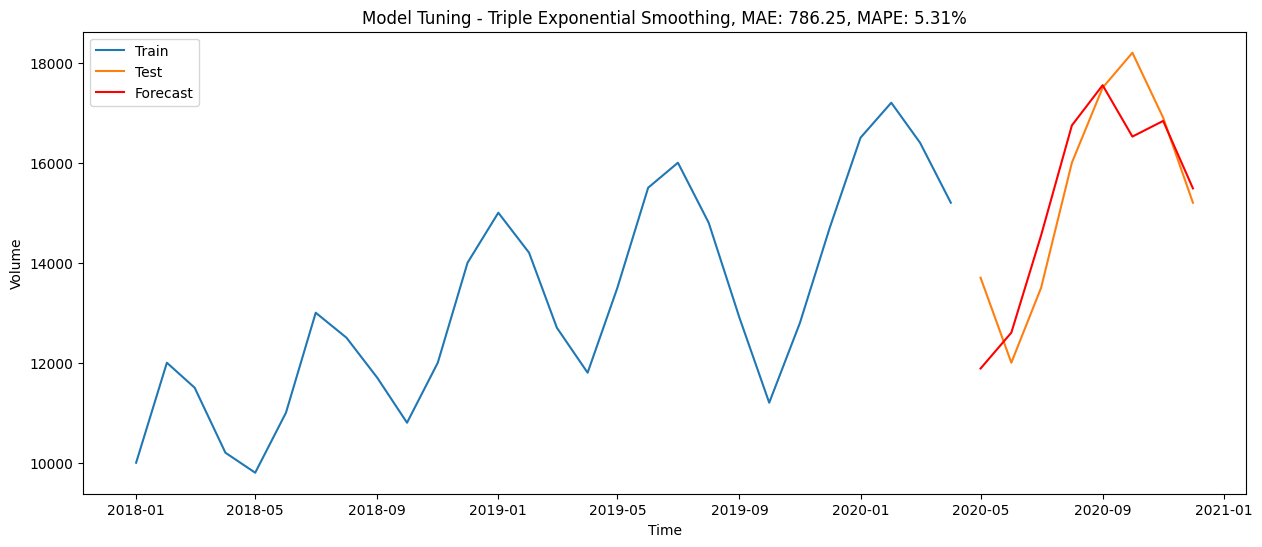

In [94]:
# Function to plot the results
def plot_model(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred) * 100  # Calculate MAPE
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, y_pred, label='Forecast', color='red')
    plt.title(f"{title}, MAE: {round(mae, 2)}, MAPE: {round(mape, 2)}%")
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

# Function to optimize TES parameters
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(
            smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]
        )
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

# Function to tune TES model and plot the results
def tes_model_tuning(train, test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
    alphas = betas = gammas = np.arange(0.05, 1, 0.05)  # Finer search grid
    abg = list(itertools.product(alphas, betas, gammas))
    best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step)

    final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit(
        smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma
    )

    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    mape = mean_absolute_percentage_error(test, y_pred) * 100

    # Print results
    print(f"Best alpha: {best_alpha:.2f}")
    print(f"Best beta: {best_beta:.2f}")
    print(f"Best gamma: {best_gamma:.2f}")
    print(f"Final MAE: {mae:.2f}")
    print(f"Final MAPE: {mape:.2f}%")

    # Plot the results
    plot_model(train, test, y_pred, title)

    return best_alpha, best_beta, best_gamma, best_mae

# Use trend='mul' and seasonal='mul' for multiplicative components
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=8, trend='mul', seasonal='mul', seasonal_periods=14)


Predicting the next 4 months

                 Date      Forecast
2021-01-01 2021-01-31  15910.127582
2021-02-01 2021-02-28  14572.400602
2021-03-01 2021-03-31  14671.479270
2021-04-01 2021-04-30  15810.798096


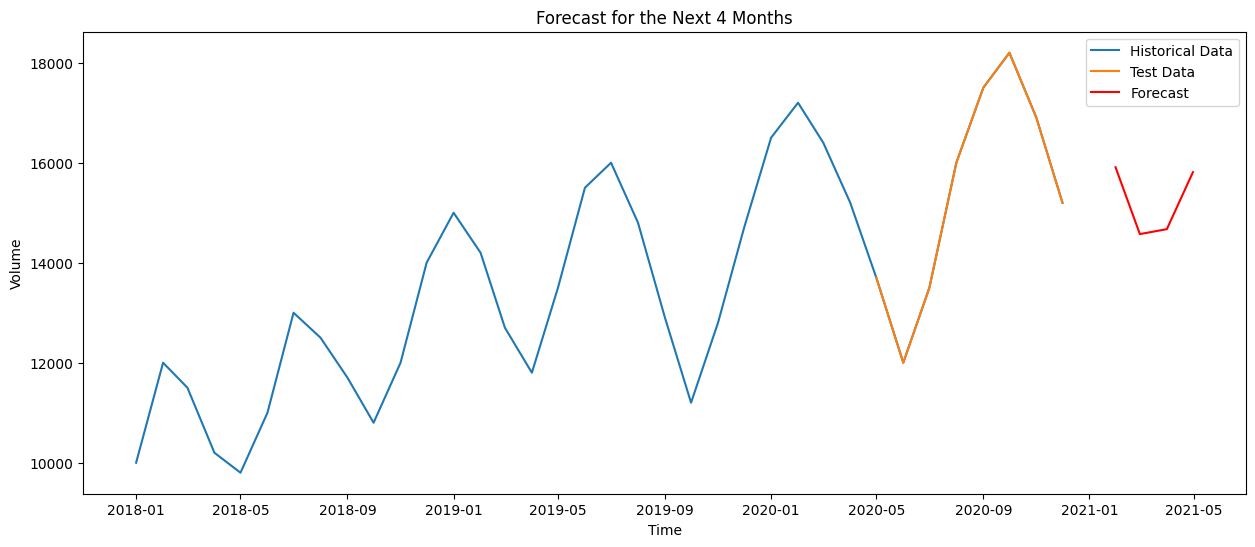

In [97]:
# Combine train and test for complete series
full_series = pd.concat([train, test])

# Define the step for forecasting the next 4 months
forecast_steps = 4

# Fit the model on the complete series WITH best alpha,beta,gamma
final_model = ExponentialSmoothing(full_series, trend='mul', seasonal='mul', seasonal_periods=14).fit(smoothing_level=0.6, smoothing_trend=0.9, smoothing_seasonal=0.25)

# Forecast the next 4 months
future_forecast = final_model.forecast(steps=forecast_steps)

# Create future dates for the forecast
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Print the forecasted values along with dates
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_forecast
})

print(forecast_df)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(full_series.index, full_series, label='Historical Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(future_dates, future_forecast, label='Forecast', color='red')
plt.title('Forecast for the Next 4 Months')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()
